In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

In [2]:
def feature_extraction(signal,feature_dictionary,f_peak):
    feature=[]
    
    if(feature_dictionary["fft_peak_frequencies"]==1):
        feature=np.concatenate((feature,f_peak.reshape(f_peak.shape[1])), axis=0);
        
    if(feature_dictionary["mean"]==1):
        mean=np.mean(signal);
        feature=np.concatenate((feature,[mean]), axis=0)
    
    if(feature_dictionary["variance"]==1):
        variance=np.var(signal)
        feature=np.concatenate((feature,[variance]), axis=0)
    #crest factor 
    if(feature_dictionary["crest_factor"]==1):
        crest_factor=np.sum(np.power(signal,2))/signal.size
        feature=np.concatenate((feature,[crest_factor]), axis=0)
    
    return np.asarray(feature)
#.reshape([feature.size,1])


def split_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        #print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
    


In [3]:

def export_signals(channels):
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    # for NIRS signal ==80 
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;


def get_feature_matrix_and_labels(channel_structure,label,features_extracted,connectivity_feature):
    list_train=[]
    list_labels=[]
    cont=0;
    index_connectivity=0;
    list_row=[]
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
           
            features=features_extracted[cont,:];
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
        list_row.append(connectivity_feature[index_connectivity,:]);
        index_connectivity=index_connectivity+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix
    

# EEG 

In [4]:
yes_EEG_contents = sio.loadmat('EEGyes.mat')
no_EEG_contents = sio.loadmat('EEGno.mat')


channels_no_EEG=no_EEG_contents["EEGno"]
channels_yes_EEG=yes_EEG_contents["EEGyes"]

"""pick_yes_EEG_contents = sio.loadmat('pick_EEG_yes_signal.mat')
pick_no_EEG_contents = sio.loadmat('pick_EEG_no_signal.mat')"""
features_extracted_yes=sio.loadmat('FeaturesYes.mat')['FeaturesYes']
features_extracted_no=sio.loadmat('FeaturesNO.mat')['FeaturesNo']
connectivity_feature_yes=sio.loadmat('ConnectivityFeaturesYes.mat')['ConnectivityFeaturesYes']
connectivity_feature_no=sio.loadmat('ConnectivityFeaturesNo.mat')['ConnectivityFeaturesNo']





channels_structure_yes_EEG=export_signals(channels_yes_EEG)
channels_structure_no_EEG=export_signals(channels_no_EEG)



train_TX_yes_EEG,EEG_yes_labels=get_feature_matrix_and_labels(channels_structure_yes_EEG,"Yes",features_extracted_yes,connectivity_feature_yes);


train_TX_no_EEG,EEG_no_labels=get_feature_matrix_and_labels(channels_structure_no_EEG,"No",features_extracted_no,connectivity_feature_no);



train_TX=np.concatenate((train_TX_yes_EEG,train_TX_no_EEG,),axis=0)

print(train_TX.shape)
labels=np.concatenate((EEG_yes_labels,EEG_no_labels),axis=0)

print(train_TX)


(60, 386)
[[51.37899203 15.24531078 11.61436394 ...  0.69780851  0.64827533
   0.55726964]
 [43.21884095 17.07002619 11.85487222 ...  0.77119732  0.59796647
   0.52598179]
 [51.22274078 15.98498462 10.37548838 ...  0.71748761  0.59170141
   0.44830244]
 ...
 [40.94839095 13.25256653 10.57481527 ...  0.79197563  0.69576433
   0.55609014]
 [47.85958135 13.49252457  9.85585227 ...  0.60220187  0.72432369
   0.48484489]
 [56.54235824 18.5951394  10.17135353 ...  0.92023203  0.70894941
   0.60492243]]


In [5]:
train_TX.shape

(60, 386)

In [31]:
# PCA on features
n = 100
pca = PCA(n_components=n)
pca.fit(train_TX)

print(pca.explained_variance_ratio_.cumsum())
train_TX_pca = pca.transform(train_TX)
train_TX_pca.shape


[0.52179653 0.67975771 0.79265547 0.87288803 0.92288719 0.96551415
 0.97496275 0.98143919 0.98613603 0.98935557 0.99239809 0.99458724
 0.99546642 0.99632709 0.99692657 0.9973799  0.9978044  0.99809817
 0.99833507 0.99855122 0.99872918 0.99888793 0.99901421 0.99913531
 0.99923817 0.99933099 0.99940594 0.9994768  0.99953695 0.99959515
 0.99964759 0.99969437 0.99973494 0.99976915 0.99980044 0.9998267
 0.99984936 0.9998694  0.99988748 0.9999037  0.99991777 0.99992992
 0.99994088 0.9999496  0.99995692 0.99996326 0.99996902 0.99997455
 0.99997933 0.99998328 0.99998677 0.99998953 0.99999176 0.99999381
 0.99999557 0.99999703 0.9999982  0.99999924 1.         1.        ]


(60, 60)

In [7]:
C_parameters= np.linspace(0.1,5,10)
k_fold=3 # number of k sub-folders to divide the set
seed = 2
max_iters = 100
kernel_types=['linear', 'rbf', 'sigmoid']
print(train_TX.shape)

best_C, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels,train_TX_pca, C_parameters, kernel_types, k_fold, seed, max_iters)



    

(60, 386)
--- Fold 0 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.75 0.825
>> Type of Kernel  rbf <<
0.45 0.525
>> Type of Kernel  sigmoid <<
0.45 0.6
>> Penalty parameter C 0.6444444444444445 <<
>> Type of Kernel  linear <<
0.75 0.825
>> Type of Kernel  rbf <<
0.45 1.0
>> Type of Kernel  sigmoid <<
0.55 0.575
>> Penalty parameter C 1.188888888888889 <<
>> Type of Kernel  linear <<
0.75 0.825
>> Type of Kernel  rbf <<
0.45 1.0
>> Type of Kernel  sigmoid <<
0.5 0.5
>> Penalty parameter C 1.7333333333333336 <<
>> Type of Kernel  linear <<
0.75 0.825
>> Type of Kernel  rbf <<
0.45 1.0
>> Type of Kernel  sigmoid <<
0.5 0.5
>> Penalty parameter C 2.277777777777778 <<
>> Type of Kernel  linear <<
0.75 0.825
>> Type of Kernel  rbf <<
0.45 1.0
>> Type of Kernel  sigmoid <<
0.5 0.5
>> Penalty parameter C 2.8222222222222224 <<
>> Type of Kernel  linear <<
0.75 0.825
>> Type of Kernel  rbf <<
0.45 1.0
>> Type of Kernel  sigmoid <<
0.5 0.5
>> Penalty parameter C 3.3666666666666

In [54]:
from sklearn import svm
best_C=best_C;
seed=range(20)
svm_total_acc = []
best_kernel_type=best_kernel_type
dataset_length=train_TX.shape[0];
for single_seed in seed:
    [i1,i2]=split_matrix_two_blocks(train_TX,0.7,0.3,single_seed)
    train=train_TX[i1,:]
    
    
    
    
    labels_train=labels[i1]
    test= train_TX[i2,:]
    labels_test=labels[i2]
    
    # PCA on features
    n = 7
    pca = PCA(n_components=n)
    pca.fit(train)

    train_pca = pca.transform(train)
    test_pca = pca.transform(test)
    #end pca
    
    #SVM classifier
    clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)


    clf.fit(train_pca, labels_train)  
    predicted_labels= clf.predict(test_pca)
    
    predicted_labels_tr= clf.predict(train_pca)
    acc_on_train = get_accuracy(predicted_labels_tr, labels_train)
    
    SVM_accuracy=get_accuracy(predicted_labels, labels_test)
    svm_total_acc.append(SVM_accuracy)
    print("Accuracy on test: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    print("Accuracy on train: "+ str(acc_on_train) + "; iteration  " + str(single_seed) )
    
print(np.mean(svm_total_acc))
print(np.std(svm_total_acc))

Accuracy on test: 0.7222222222222222; iteration  0
Accuracy on train: 0.8809523809523809; iteration  0
Accuracy on test: 0.6666666666666666; iteration  1
Accuracy on train: 0.8571428571428571; iteration  1
Accuracy on test: 0.7777777777777778; iteration  2
Accuracy on train: 0.9285714285714286; iteration  2
Accuracy on test: 0.7777777777777778; iteration  3
Accuracy on train: 0.8809523809523809; iteration  3
Accuracy on test: 0.6666666666666666; iteration  4
Accuracy on train: 0.9285714285714286; iteration  4
Accuracy on test: 0.8888888888888888; iteration  5
Accuracy on train: 0.8571428571428571; iteration  5
Accuracy on test: 0.5555555555555556; iteration  6
Accuracy on train: 0.8571428571428571; iteration  6
Accuracy on test: 0.8333333333333334; iteration  7
Accuracy on train: 0.9285714285714286; iteration  7
Accuracy on test: 0.6111111111111112; iteration  8
Accuracy on train: 0.9285714285714286; iteration  8
Accuracy on test: 0.6111111111111112; iteration  9
Accuracy on train: 0.7

KeyboardInterrupt: 

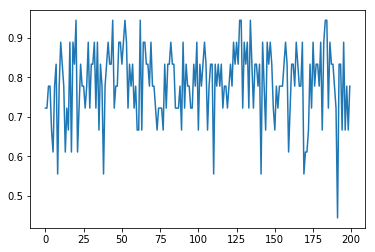

In [50]:
idx = 4
plt.plot(svm_total_acc)
plt.show()

In [14]:
print(np.mean(svm_total_acc))
print(np.std(svm_total_acc))

0.6977777777777777
0.1270073391482983


In [27]:
from sklearn import svm

def explore_dim_pca_effectiveness_SMV(n_dim, best_C_input, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train, num_experiments):
    best_C=best_C_input;
    seed=range(num_experiments)
    svm_total_acc = []
    best_kernel_type=best_kernel_type
    dataset_length=train_TX.shape[0];
    for single_seed in seed:
        [i1,i2]=split_matrix_two_blocks(train_TX,0.7,0.3,single_seed)
        train=train_TX[i1,:]




        labels_train=labels[i1]
        test= train_TX[i2,:]
        labels_test=labels[i2]

        # PCA on features
        pca = PCA(n_components=n_dim)
        pca.fit(train)

        train_pca = pca.transform(train)
        test_pca = pca.transform(test)
        #end pca

        #SVM classifier
        clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)


        clf.fit(train_pca, labels_train)  
        predicted_labels= clf.predict(test_pca)


        SVM_accuracy=get_accuracy(predicted_labels, labels_test)
        svm_total_acc.append(SVM_accuracy)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return [np.mean(svm_total_acc), np.std(svm_total_acc)]

In [28]:
n_dim_experiment = [4,5,7,10,13,20,40,60]

perf_mean = []
perf_std = []
for dim_to_retain in n_dim_experiment:
    [mean_acc, std_acc] = explore_dim_pca_effectiveness_SMV(dim_to_retain, best_C, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train, 25)
    print("with " +str(dim_to_retain)+ " features dimension")
    print(mean_acc)
    print(std_acc)
    perf_mean.append(mean_acc)
    perf_std.append(std_acc)
    
print(n_dim_experiment)
print(perf_mean)
print(perf_std)





with 4 features dimension
0.5555555555555556
0.11331154474650633
with 5 features dimension
0.5244444444444444
0.1007135039433303
with 7 features dimension
0.6866666666666665
0.11954646805611348
with 10 features dimension
0.74
0.1204108194146139
with 13 features dimension
0.7333333333333334
0.11967032904743342
with 20 features dimension
0.7311111111111112
0.107358865148277
with 40 features dimension
0.7511111111111112
0.10076252487781895
with 60 features dimension
0.7533333333333334
0.10193195503270855
[4, 5, 7, 10, 13, 20, 40, 60]
[0.5555555555555556, 0.5244444444444444, 0.6866666666666665, 0.74, 0.7333333333333334, 0.7311111111111112, 0.7511111111111112, 0.7533333333333334]
[0.11331154474650633, 0.1007135039433303, 0.11954646805611348, 0.1204108194146139, 0.11967032904743342, 0.107358865148277, 0.10076252487781895, 0.10193195503270855]


In [25]:
8*7

56